<a href="https://colab.research.google.com/github/Debabrata04/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Speech Emotion Recognition - Fixed Version for Colab

# Step 1: Install required packages
!pip install librosa numpy pandas scikit-learn tensorflow matplotlib

# Step 2: Import libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Step 3: Create directories
!mkdir -p data/speech
!mkdir -p data/song

# Step 4: Download and extract RAVDESS dataset
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O speech.zip
!wget https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip -O song.zip
!unzip -q speech.zip -d data/speech/
!unzip -q song.zip -d data/song/

# Step 5: Create proper metadata dataframe
def create_metadata():
    data = []
    for root, dirs, files in os.walk('data'):
        for file in files:
            if file.endswith('.wav'):
                try:
                    parts = file[:-4].split('-')  # Remove .wav before splitting
                    if len(parts) == 7:  # Check we have all parts
                        data.append({
                            'filepath': os.path.join(root, file),
                            'modality': int(parts[0]),
                            'vocal_channel': int(parts[1]),
                            'emotion': int(parts[2]),
                            'intensity': int(parts[3]),
                            'statement': int(parts[4]),
                            'repetition': int(parts[5]),
                            'actor': int(parts[6])  # Actor number is the last part
                        })
                except:
                    continue
    return pd.DataFrame(data)

metadata = create_metadata()

# Verify we have data
print(f"Found {len(metadata)} audio files")
print(metadata.head())

# Emotion labels mapping
emotion_labels = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}

# Add emotion labels only if 'emotion' column exists
if 'emotion' in metadata.columns:
    metadata['emotion_label'] = metadata['emotion'].map(emotion_labels)
else:
    raise ValueError("'emotion' column not found in metadata - check file naming convention")
# Step 6: Feature extraction
def extract_features(filepath, vocal_channel):
    try:
        signal, sr = librosa.load(filepath, sr=22050, duration=3)  # Load 3 seconds
        if len(signal) < 22050 * 3:
            signal = np.pad(signal, (0, 22050 * 3 - len(signal)))

        # MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
        spec_cent_mean = np.mean(spectral_centroid)
        spec_cent_std = np.std(spectral_centroid)

        features = {
            'mfcc_mean': mfcc_mean,
            'mfcc_std': mfcc_std,
            'chroma_mean': chroma_mean,
            'chroma_std': chroma_std,
            'spec_cent_mean': spec_cent_mean,
            'spec_cent_std': spec_cent_std,
            'is_song': 1 if vocal_channel == 2 else 0,
            'emotion': emotion_labels[int(parts[2])]
        }
        return features
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None

# Extract features (this may take 10-15 minutes)
features = []
for idx, row in metadata.iterrows():
    feat = extract_features(row['filepath'], row['vocal_channel'])
    if feat:
        features.append(feat)

# Convert to DataFrame
features_df = pd.DataFrame(features)

# Step 7: Prepare data for training
X = np.array([np.concatenate([
    feat['mfcc_mean'],
    feat['mfcc_std'],
    feat['chroma_mean'],
    feat['chroma_std'],
    [feat['spec_cent_mean']],
    [feat['spec_cent_std']],
    [feat['is_song']]
]) for feat in features])

# Encode labels
le = LabelEncoder()
y = le.fit_transform([f['emotion'] for f in features])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Build and train model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(emotion_labels), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Step 9: Evaluate model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load best model
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2f}")

# Step 10: Prediction example
def predict_emotion(audio_path):
    features = extract_features(audio_path, vocal_channel=1)  # Assuming speech
    if features:
        x = np.concatenate([
            features['mfcc_mean'],
            features['mfcc_std'],
            features['chroma_mean'],
            features['chroma_std'],
            [features['spec_cent_mean']],
            [features['spec_cent_std']],
            [features['is_song']]
        ]).reshape(1, -1)
        x = scaler.transform(x)
        pred = model.predict(x)
        return emotion_labels[np.argmax(pred) + 1]  # +1 because emotions start at 1
    return "Could not process file"

# Test with a sample file
sample_file = 'data/speech/Actor_01/03-01-01-01-01-01-01.wav'
print(f"Predicted emotion: {predict_emotion(sample_file)}")

--2025-06-20 12:31:39--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-06-20 12:31:40--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘speech.zip’

speech.zip          100%[===================>] 198.81M  11.4MB/s    in 13s     

2025-06-20 12:31:53 (15.1 MB/s) - ‘speech.zip’ saved [208468073/208468073]

--2025-06-20 12:31:53--  https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connec

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.


Found 2452 valid audio files
                                        filepath  modality  vocal_channel  \
0  data/speech/Actor_10/03-01-03-02-02-01-10.wav         3              1   
1  data/speech/Actor_10/03-01-06-02-02-02-10.wav         3              1   
2  data/speech/Actor_10/03-01-04-01-02-01-10.wav         3              1   
3  data/speech/Actor_10/03-01-01-01-01-02-10.wav         3              1   
4  data/speech/Actor_10/03-01-07-02-02-02-10.wav         3              1   

   emotion  intensity  statement  repetition  actor  
0        3          2          2           1     10  
1        6          2          2           2     10  
2        4          1          2           1     10  
3        1          1          1           2     10  
4        7          2          2           2     10  

Emotion distribution:
emotion_label
happy        376
fearful      376
sad          376
angry        376
calm         376
disgust      192
surprised    192
neutral      188
Name: coun

100%|██████████| 2452/2452 [01:27<00:00, 27.93it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Successfully extracted features from 2452 files

Data shapes:
X_train: (1961, 107)
X_test: (491, 107)
y_train: (1961,)
y_test: (491,)

Training model...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2013 - loss: 2.4584

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.2018 - loss: 2.4556 - val_accuracy: 0.4175 - val_loss: 1.6978
Epoch 2/100
54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3548 - loss: 1.7895

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3562 - loss: 1.7847 - val_accuracy: 0.5275 - val_loss: 1.4271
Epoch 3/100
59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4086 - loss: 1.5899

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4100 - loss: 1.5876 - val_accuracy: 0.5906 - val_loss: 1.2482
Epoch 4/100
52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4731 - loss: 1.4275

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4758 - loss: 1.4196 - val_accuracy: 0.6130 - val_loss: 1.1374
Epoch 5/100
49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5273 - loss: 1.2778

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5277 - loss: 1.2788 - val_accuracy: 0.6293 - val_loss: 1.0721
Epoch 6/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5454 - loss: 1.2235

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5454 - loss: 1.2235 - val_accuracy: 0.6497 - val_loss: 1.0221
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5559 - loss: 1.1742

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5561 - loss: 1.1739 - val_accuracy: 0.6640 - val_loss: 0.9928
Epoch 8/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5744 - loss: 1.1368

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5747 - loss: 1.1361 - val_accuracy: 0.6619 - val_loss: 0.9632
Epoch 9/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6070 - loss: 1.1065

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6077 - loss: 1.1048 - val_accuracy: 0.6721 - val_loss: 0.9505
Epoch 10/100
42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6072 - loss: 1.0547

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6077 - loss: 1.0474 - val_accuracy: 0.6884 - val_loss: 0.9060
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6416 - loss: 0.9660 - val_accuracy: 0.6802 - val_loss: 0.9065
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6431 - loss: 0.9532

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6432 - loss: 0.9533 - val_accuracy: 0.6986 - val_loss: 0.8927
Epoch 13/100
48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6935 - loss: 0.8999

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6909 - loss: 0.8993 - val_accuracy: 0.6925 - val_loss: 0.8903
Epoch 14/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.8843

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6861 - loss: 0.8862 - val_accuracy: 0.6823 - val_loss: 0.8659
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6781 - loss: 0.8748 - val_accuracy: 0.6762 - val_loss: 0.8687
Epoch 16/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6992 - loss: 0.8115

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6987 - loss: 0.8130 - val_accuracy: 0.6843 - val_loss: 0.8598
Epoch 17/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6930 - loss: 0.8378

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6934 - loss: 0.8369 - val_accuracy: 0.7006 - val_loss: 0.8388
Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7049 - loss: 0.7898 - val_accuracy: 0.6904 - val_loss: 0.8580
Epoch 19/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6999 - loss: 0.7908 - val_accuracy: 0.7108 - val_loss: 0.8420
Epoch 20/100
59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7185 - loss: 0.7966

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7183 - loss: 0.7969 - val_accuracy: 0.7026 - val_loss: 0.8107
Epoch 21/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7293 - loss: 0.7457 - val_accuracy: 0.7026 - val_loss: 0.8363
Epoch 22/100
57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7317 - loss: 0.7375

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7312 - loss: 0.7391 - val_accuracy: 0.7210 - val_loss: 0.7739
Epoch 23/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7456 - loss: 0.7143 - val_accuracy: 0.7108 - val_loss: 0.7824
Epoch 24/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7439 - loss: 0.6975

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7439 - loss: 0.6980 - val_accuracy: 0.7271 - val_loss: 0.7673
Epoch 25/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7601 - loss: 0.6668 - val_accuracy: 0.7189 - val_loss: 0.7867
Epoch 26/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7727 - loss: 0.6416 - val_accuracy: 0.7251 - val_loss: 0.7970
Epoch 27/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7596 - loss: 0.6442 - val_accuracy: 0.7271 - val_loss: 0.7830
Epoch 28/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7754 - loss: 0.6182 - val_accuracy: 0.7251 - val_loss: 0.7838
Epoch 29/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7713 - loss: 0.6099 - val_accuracy: 0.7251 - val_loss: 0.7761
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7824 - loss: 0.6066 - val_accuracy: 0.7332 - val_loss: 0.7704
Epoch 31/100
54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7633 - loss: 0.6497

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7630 - loss: 0.6499 - val_accuracy: 0.7251 - val_loss: 0.7597
Epoch 32/100
52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7847 - loss: 0.6304

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7842 - loss: 0.6287 - val_accuracy: 0.7352 - val_loss: 0.7586
Epoch 33/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7781 - loss: 0.6144

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7781 - loss: 0.6152 - val_accuracy: 0.7434 - val_loss: 0.7472
Epoch 34/100
60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.5765

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7999 - loss: 0.5773 - val_accuracy: 0.7495 - val_loss: 0.7325
Epoch 35/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.5938 - val_accuracy: 0.7291 - val_loss: 0.7388
Epoch 36/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8060 - loss: 0.5146

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8055 - loss: 0.5158 - val_accuracy: 0.7536 - val_loss: 0.7227
Epoch 37/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8210 - loss: 0.5254 - val_accuracy: 0.7617 - val_loss: 0.7286
Epoch 38/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8089 - loss: 0.5503 - val_accuracy: 0.7454 - val_loss: 0.7586
Epoch 39/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8173 - loss: 0.5212 - val_accuracy: 0.7475 - val_loss: 0.7524
Epoch 40/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8100 - loss: 0.5569 - val_accuracy: 0.7556 - val_loss: 0.7438
Epoch 41/100
59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8182 - loss: 0.4871

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8177 - loss: 0.4886 - val_accuracy: 0.7637 - val_loss: 0.7226
Epoch 42/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8026 - loss: 0.5051 - val_accuracy: 0.7576 - val_loss: 0.7262
Epoch 43/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.4972

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8244 - loss: 0.4974 - val_accuracy: 0.7576 - val_loss: 0.7194
Epoch 44/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8198 - loss: 0.4861 - val_accuracy: 0.7536 - val_loss: 0.7198
Epoch 45/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8374 - loss: 0.4677

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8373 - loss: 0.4681 - val_accuracy: 0.7617 - val_loss: 0.7055
Epoch 46/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.5329 - val_accuracy: 0.7617 - val_loss: 0.7143
Epoch 47/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8331 - loss: 0.4861 - val_accuracy: 0.7597 - val_loss: 0.7316
Epoch 48/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8412 - loss: 0.4713 - val_accuracy: 0.7536 - val_loss: 0.7202
Epoch 49/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.4518 - val_accuracy: 0.7454 - val_loss: 0.7396
Epoch 50/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8577 - loss: 0.4279 - val_accuracy: 0.7536 - val_loss: 0.7122
Epoch 51/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8529 - loss: 0.4404 - val_accuracy: 0.7576 - val_loss: 0.7165
Epoch 52/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8338 - loss: 0.4747 - val_accuracy: 0.7556 - val_lo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8498 - loss: 0.4345 - val_accuracy: 0.7658 - val_loss: 0.6948
Epoch 56/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.4234 - val_accuracy: 0.7556 - val_loss: 0.7063
Epoch 57/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8440 - loss: 0.4204 - val_accuracy: 0.7637 - val_loss: 0.7138
Epoch 58/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8571 - loss: 0.3870 - val_accuracy: 0.7637 - val_loss: 0.7203
Epoch 59/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.4247 - val_accuracy: 0.7617 - val_loss: 0.7503
Epoch 60/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8638 - loss: 0.3880 - val_accuracy: 0.7556 - val_loss: 0.7568
Epoch 61/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8703 - loss: 0.3556 - val_accuracy: 0.7617 - val_loss: 0.7494
Epoch 62/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8656 - loss: 0.3908 - val_accuracy: 0.7658 - val_lo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.3925 - val_accuracy: 0.7719 - val_loss: 0.6691
Epoch 66/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3537 - val_accuracy: 0.7780 - val_loss: 0.6800
Epoch 67/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8655 - loss: 0.3869 - val_accuracy: 0.7739 - val_loss: 0.7023
Epoch 68/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8846 - loss: 0.3471 - val_accuracy: 0.7841 - val_loss: 0.6710
Epoch 69/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8776 - loss: 0.3767 - val_accuracy: 0.7800 - val_loss: 0.6823
Epoch 70/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8848 - loss: 0.3323 - val_accuracy: 0.7576 - val_loss: 0.7049
Epoch 71/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8717 - loss: 0.3808 - val_accuracy: 0.7576 - val_loss: 0.7103
Epoch 72/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8746 - loss: 0.3556 - val_accuracy: 0.7780 - val_lo

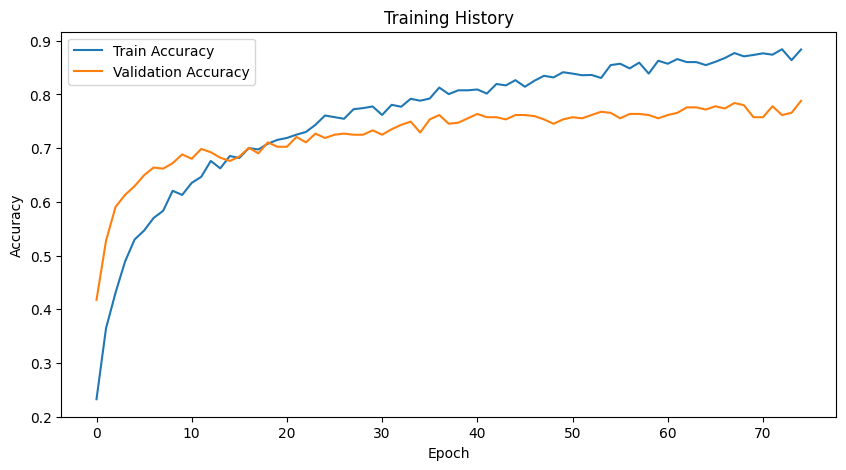


Test Accuracy: 0.7719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step



Sample file: data/speech/Actor_10/03-01-03-02-02-01-10.wav
Predicted emotion: happy
Actual emotion: happy

Model saved as emotion_classifier.h5


In [ ]:
def create_metadata():
    data = []
    for root, dirs, files in os.walk('data'):
        for file in files:
            if file.endswith('.wav'):
                try:
                    # Remove .wav and split filename
                    base_name = file[:-4]
                    parts = base_name.split('-')
                    if len(parts) != 7:
                        continue

                    # Convert all parts to integers
                    parts = [int(p) for p in parts]

                    # Validate emotion code (1-8)
                    if parts[2] < 1 or parts[2] > 8:
                        continue

                    data.append({
                        'filepath': os.path.join(root, file),
                        'modality': parts[0],
                        'vocal_channel': parts[1],
                        'emotion': parts[2],
                        'intensity': parts[3],
                        'statement': parts[4],
                        'repetition': parts[5],
                        'actor': parts[6]
                    })
                except (ValueError, IndexError) as e:
                    print(f"Skipping {file}: {str(e)}")
                    continue
    return pd.DataFrame(data)

metadata = create_metadata()

# Verify we have data
print(f"\nFound {len(metadata)} valid audio files")
print(metadata.head())

# Emotion labels mapping
emotion_labels = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}

# Add emotion labels
metadata['emotion_label'] = metadata['emotion'].map(emotion_labels)

# Show distribution of emotions
print("\nEmotion distribution:")
print(metadata['emotion_label'].value_counts())

# Step 6: Fixed feature extraction function
def extract_features(filepath, vocal_channel, emotion_code):
    try:
        # Load audio file
        signal, sr = librosa.load(filepath, sr=22050, duration=3)
        if len(signal) < 22050 * 3:
            signal = np.pad(signal, (0, 22050 * 3 - len(signal)))

        # MFCCs
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr)

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]

        return {
            'mfcc_mean': np.mean(mfcc, axis=1),
            'mfcc_std': np.std(mfcc, axis=1),
            'chroma_mean': np.mean(chroma, axis=1),
            'chroma_std': np.std(chroma, axis=1),
            'spec_cent_mean': np.mean(spectral_centroid),
            'spec_cent_std': np.std(spectral_centroid),
            'is_song': 1 if vocal_channel == 2 else 0,
            'emotion': emotion_labels[emotion_code]  # Use emotion_code directly
        }
    except Exception as e:
        print(f"\nError processing {filepath}: {str(e)}")
        return None

# Extract features with progress bar
print("\nExtracting features...")
features = []
for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    feat = extract_features(
        filepath=row['filepath'],
        vocal_channel=row['vocal_channel'],
        emotion_code=row['emotion']  # Pass emotion code directly
    )
    if feat:
        features.append(feat)

# Convert to DataFrame
features_df = pd.DataFrame(features)
print(f"\nSuccessfully extracted features from {len(features_df)} files")

# Step 7: Prepare data for training
# Create feature vectors
X = []
for _, row in features_df.iterrows():
    feature_vector = np.concatenate([
        row['mfcc_mean'],
        row['mfcc_std'],
        row['chroma_mean'],
        row['chroma_std'],
        [row['spec_cent_mean']],
        [row['spec_cent_std']],
        [row['is_song']]
    ])
    X.append(feature_vector)

X = np.array(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(features_df['emotion'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Step 8: Build and train model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(emotion_labels), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Step 9: Evaluate model
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.savefig('training_history.png')
plt.show()

# Load best model
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Step 10: Prediction function
def predict_emotion(audio_path, is_song=False):
    try:
        # Extract features using the same function
        features = extract_features(
            filepath=audio_path,
            vocal_channel=2 if is_song else 1,
            emotion_code=1  # Dummy value, not used for prediction
        )
        if not features:
            return "Could not extract features"

        # Build feature vector
        x = np.concatenate([
            features['mfcc_mean'],
            features['mfcc_std'],
            features['chroma_mean'],
            features['chroma_std'],
            [features['spec_cent_mean']],
            [features['spec_cent_std']],
            [features['is_song']]
        ]).reshape(1, -1)

        # Scale and predict
        x = scaler.transform(x)
        pred = model.predict(x)
        predicted_emotion = le.inverse_transform([np.argmax(pred)])[0]
        return predicted_emotion
    except Exception as e:
        return f"Prediction error: {str(e)}"

# Test with a sample file
sample_file = metadata.iloc[0]['filepath']
is_song = metadata.iloc[0]['vocal_channel'] == 2
predicted = predict_emotion(sample_file, is_song)
print(f"\nSample file: {sample_file}")
print(f"Predicted emotion: {predicted}")
print(f"Actual emotion: {metadata.iloc[0]['emotion_label']}")

# Save the model for later use
model.save('emotion_classifier.h5')
print("\nModel saved as emotion_classifier.h5")